In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from typing import Optional, Sequence

import numpy as np

from coba import CobaRandom, Environments, RandomLearner, Experiment, VowpalBagLearner
from coba.environments import LambdaSimulation
from coba.experiments.results import CustomResult
from coba.experiments.tasks import SimpleEvaluation
from coba.primitives import Context, Action

# Run Simulation

In [17]:
class CustomEnvironment(LambdaSimulation):
    def __init__(self, n_interactions: Optional[int] = 1000):
        super().__init__(n_interactions, self.context, self.actions, self.rewards)
        self.r = CobaRandom(1)

    def actions(self, index: int, context: Context) -> Sequence[Action]:
        """
        actions: A function that should return all valid actions for a given index, context and random state.
        """
        return [0, 1]

    def context(self, index: int) -> Context:
        return {
            "feature_1": self.r.randoms(1)[0],
            "feature_2": self.r.randoms(1)[0],
            "feature_3": self.r.randoms(1)[0]
        }

    def rewards(self, index: int, context: Context, action: Action) -> float:
        # reward centered around 0.5, with feature_1 strongly positively correlating with the reward for the first action 
        # and feature_2 half as much negatively correlating
        reward_probabilities_for_actions = [
            0.5 
                + 1.0 * (context["feature_1"] - 0.5) 
                - 0.5 * (context["feature_2"] - 0.5),
            0.5
        ]
        
        reward_probabilities_for_actions = [min(1.0, max(0.0, prob)) for prob in reward_probabilities_for_actions]
        return np.random.binomial(1, reward_probabilities_for_actions[action])

environments = Environments([CustomEnvironment(5000)]).shuffle(n=4)
learners = [
    VowpalBagLearner(features=[1, 'x', 'a', 'axx']),
    VowpalBagLearner(features=[1, 'x', 'a', 'axx'], epsilon=0.01),
    VowpalBagLearner(features=[1, 'x', 'a', 'axx'], epsilon=0.05),
    VowpalBagLearner(features=[1, 'x', 'a', 'axx'], epsilon=0.1),
    VowpalBagLearner(features=[1, 'x', 'a', 'axx'], epsilon=0.2),
]
learners.append(RandomLearner())

result = Experiment(
    environments,
    learners,
    evaluation_task=SimpleEvaluation(record=['reward','probability','action','context'])
).run()
result.__class__ = CustomResult

2023-01-27 09:26:04 -- Processing chunk...
2023-01-27 09:26:04 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Recording Learner 3 parameters... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Recording Learner 4 parameters... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Recording Learner 5 parameters... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2023-01-27 09:26:04 --   * Peeking at Environment 0... (0.07 seconds) (completed)
2023-01-27 09:26:04 --   * Evaluating Learner 0 on Environment 0... (0.23 seconds) (completed)
2023-01-27 09:26:04 --   * Peeking at Environment 0... (0.02 seconds) (completed)
2023-01-27 09:26:05 --   * Evaluating Learner 1 on Environment 0... (0.23 seconds) (c

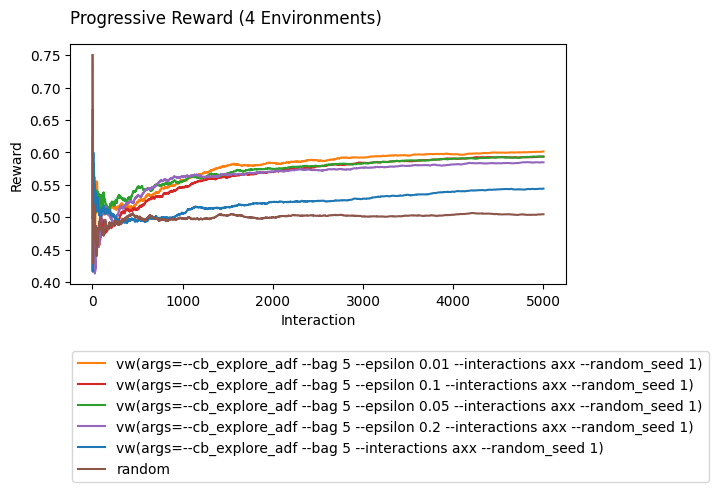

In [18]:
result.plot_learners()

array([[<AxesSubplot: title={'center': 'reward'}>]], dtype=object)

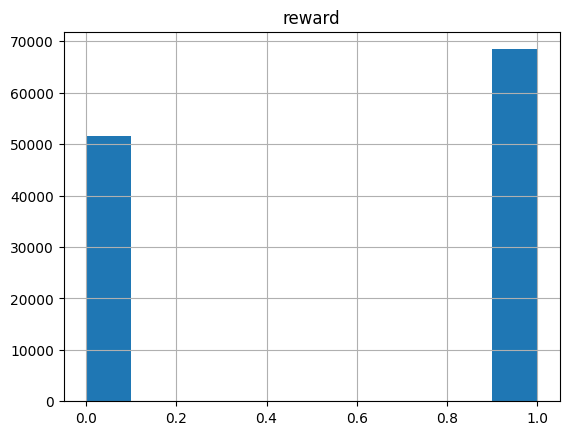

In [19]:
df = result.interactions.to_pandas()
df.hist(column='reward')

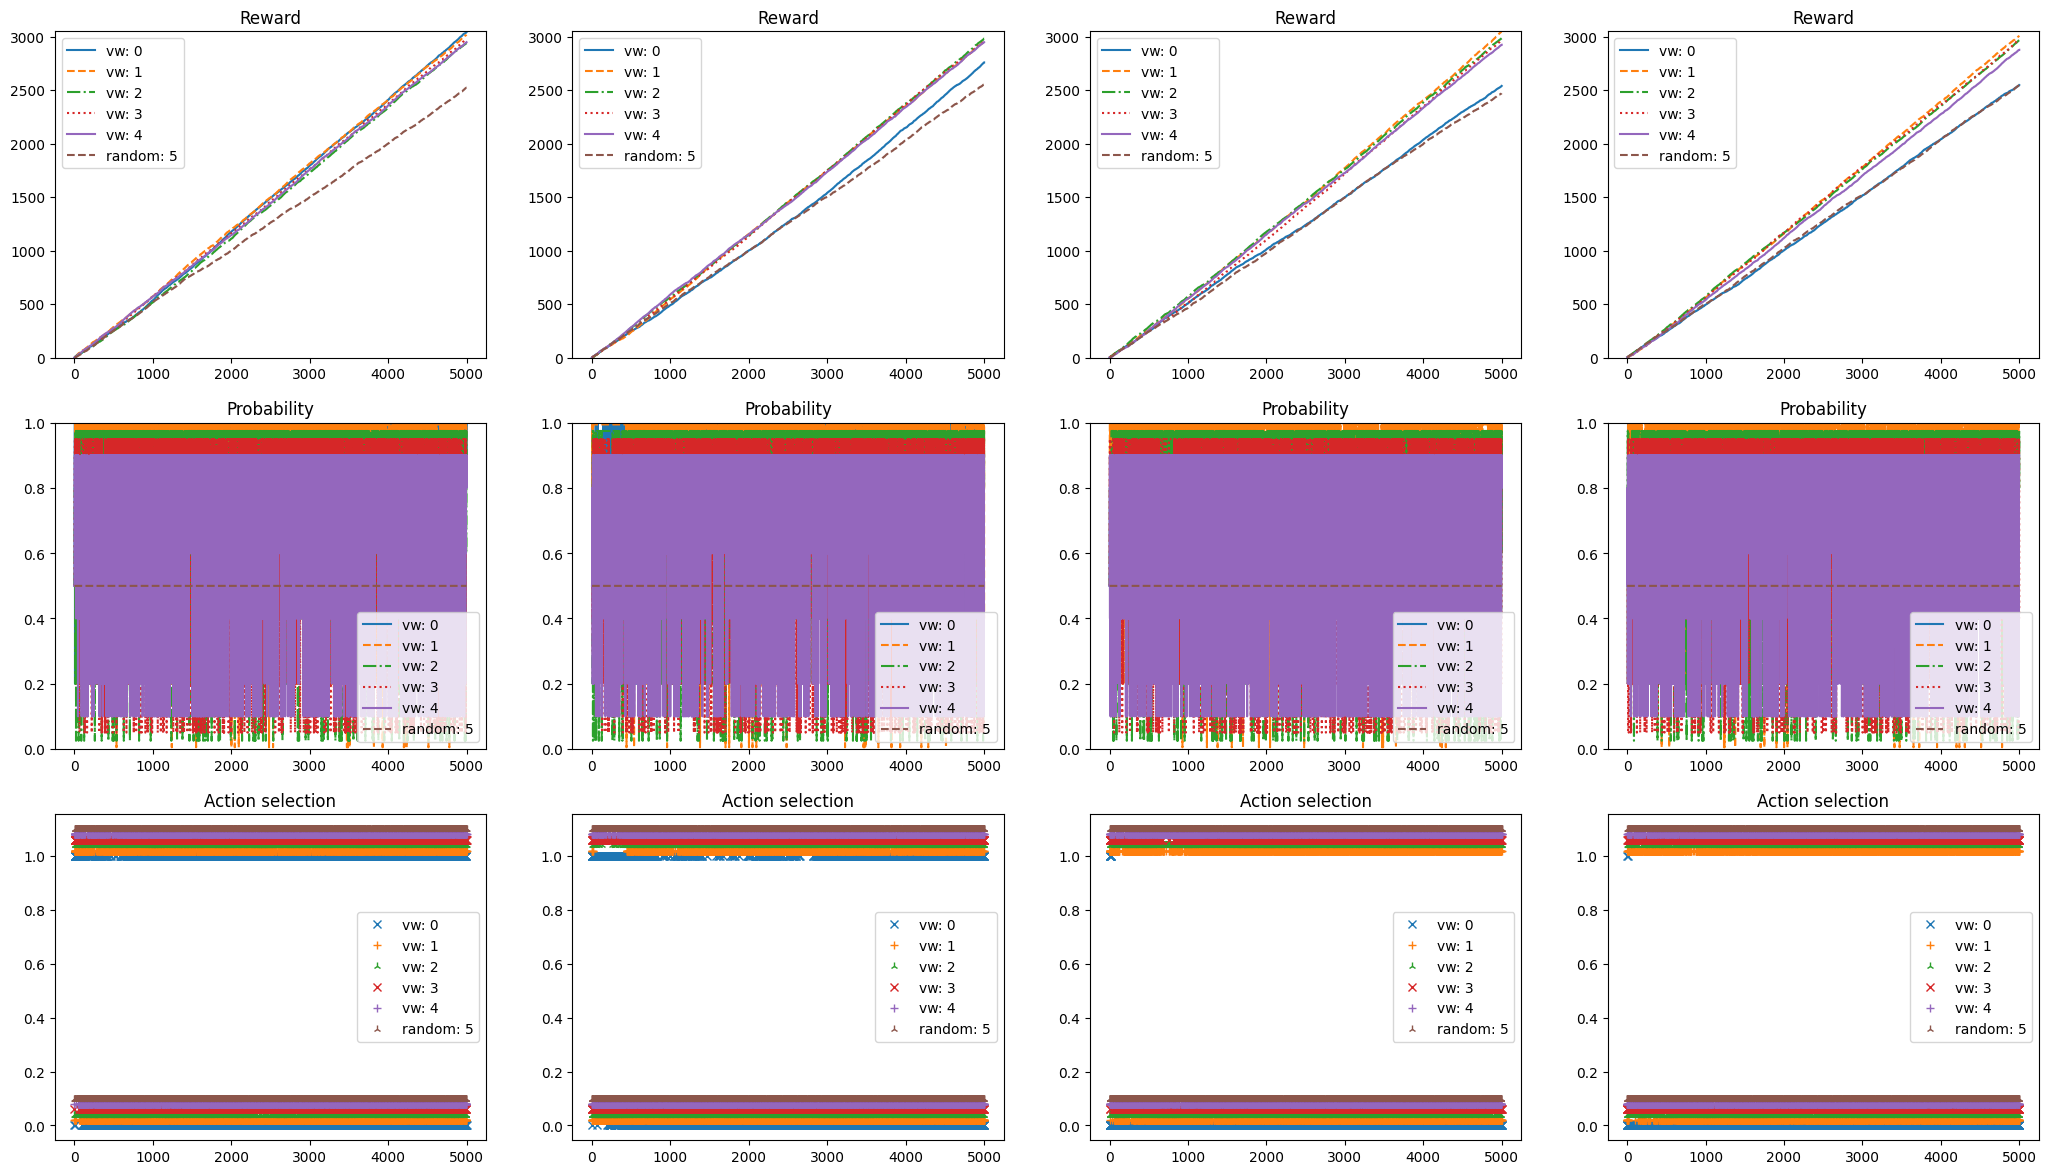

In [20]:
result.plot_overview()

In [21]:
result.eval_metrics()

,learners,reward,action,probability,environment_variance
learner_id,,,,,
1,vw: --cb_explore_adf --bag 5 --epsilon 0.01 --...,0.60155,0.4675,0.896754,0.000059
3,vw: --cb_explore_adf --bag 5 --epsilon 0.1 --i...,0.59365,0.4732,0.810347,0.000006
2,vw: --cb_explore_adf --bag 5 --epsilon 0.05 --...,0.59355,0.4882,0.838059,0.000017
4,vw: --cb_explore_adf --bag 5 --epsilon 0.2 --i...,0.58485,0.5049,0.757975,0.000045
0,vw: --cb_explore_adf --bag 5 --interactions ax...,0.54435,0.1790,0.952305,0.002238
5,random: N/A,0.50480,0.4912,0.500000,0.000059


# Findings
Adding a small amount of epsilon exploration significantly improves performance by about 10%